# Model Exercises

### Using saas.csv or log data from API usage or store_item_sales

1. Split data (train/validate/test) and resample by any period, except daily, and aggregate using the sum.
2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
    - Simple Average
    - Moving Average
    - Holt's Linear Trend Model
    - Based on previous year/month/etc., this is up to you.

In [1]:
# imports
import pandas as pd
import numpy as np
import os

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

from matplotlib.ticker import StrMethodFormatter
from matplotlib.dates import DateFormatter

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")

In [2]:
url = 'https://ds.codeup.com/saas.csv'
df = pd.read_csv(url)
print('shape:', df.shape)
df.head()

shape: (790458, 5)


,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [3]:
# Lowercase column names
df.columns = [col.lower() for col in df]

In [4]:
# Properly parse the datetime field
df.month_invoiced = pd.to_datetime(df.month_invoiced)

In [5]:
df.head()

,month_invoiced,customer_id,invoice_id,subscription_type,amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   month_invoiced     790458 non-null  datetime64[ns]
 1   customer_id        790458 non-null  int64         
 2   invoice_id         790458 non-null  int64         
 3   subscription_type  790458 non-null  float64       
 4   amount             790458 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 30.2 MB


In [7]:
df.subscription_type = df.subscription_type.astype(int)
df.amount = df.amount.astype(int)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   month_invoiced     790458 non-null  datetime64[ns]
 1   customer_id        790458 non-null  int64         
 2   invoice_id         790458 non-null  int64         
 3   subscription_type  790458 non-null  int64         
 4   amount             790458 non-null  int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 30.2 MB


In [9]:
# a datetime index is probably a good idea
df = df.set_index('month_invoiced')

In [10]:
df = df.groupby(['month_invoiced']).amount.sum().reset_index()

In [11]:
df = df[df.index!='2016-02-29']

In [12]:
df = df.set_index('month_invoiced').sort_index()

In [13]:
df.head()

,amount
month_invoiced,
2014-01-31,35850
2014-02-28,37190
2014-03-31,38295
2014-04-30,39255
2014-05-31,40355


In [14]:
df_size = len(df)
df_size

48

In [15]:
len(df) * .5

24.0

In [16]:
# compute num of rows that are 50% of total rows and assign to variable train_size
train_size = int(len(df) * .5)
train_size

24

In [17]:
# compute num of rows that are 30% of total rows and assign to variable validate_size
validate_size = int(len(df) * .3)
validate_size

14

In [18]:
test_size = int(len(df) - train_size - validate_size)
test_size

10

In [19]:
# compute the row number at which the switch from validate to test happens. 
validate_end_index = train_size + validate_size
validate_end_index

38

In [20]:
# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

In [21]:
train.head()

,amount
month_invoiced,
2014-01-31,35850
2014-02-28,37190
2014-03-31,38295
2014-04-30,39255
2014-05-31,40355


In [22]:
# sum of train, validate and test = total number of rows? 
print(len(train) + len(validate) + len(test) == len(df))

True


In [23]:
# test the row starts
print(df.head(1) == train.head(1))

                amount
month_invoiced        
2014-01-31        True


In [24]:
# test the split between validate and test
pd.concat([train.tail(1), validate.head(1)])
pd.concat([validate.tail(1), test.head(1)])

,amount
month_invoiced,
2017-02-28,53440
2017-03-31,53480


In [25]:
# compare the last row of test to last row of df
pd.concat([test.tail(1), df.tail(1)])

,amount
month_invoiced,
2017-12-31,53805
2017-12-31,53805


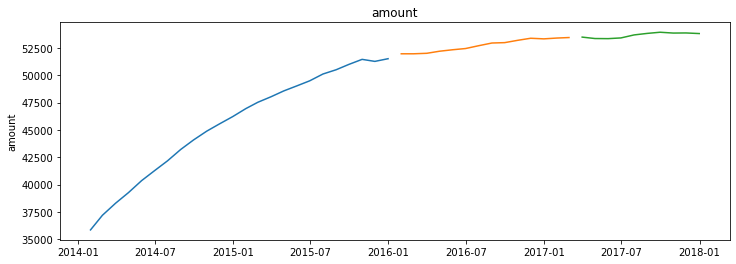

In [26]:
# plot the data points, color by train, validate, test
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [27]:
# define evaluation function to compute rmse

def evaluate(target_var):
    '''
    the evaluate function will take in the actual values in validate and the predicted values and compute the 
    mean squared error and then take the square root and round to zero decimals
    it will return the rmse 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [28]:
# plot and evaluate: plot
def plot_and_eval(target_var):
    '''
    a function to evaluate forecasts by computing the rmse and plot train and validate along with predictions
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    
    plt.show()

In [29]:
# Create the empty dataframe with model_type, target_var, rmse
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

In [30]:
# check out the data frame
eval_df

,model_type,target_var,rmse


In [31]:
# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    '''
    this function is going to take in the mode_type as a string, the target variable as a string
    and rund the evaluate() function to compute the rmse,
    and append the dataframe a row with the model_type, target_var, and rmse.
    it will return the new dataframe
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

## Simple Average

In [32]:
amounts = round(train['amount'].mean(),2)

In [33]:
def make_predictions():
    yhat_df = pd.DataFrame({'amount': [amounts],
                           }, index = validate.index)
    return yhat_df

In [34]:
yhat_df = make_predictions()

In [35]:
yhat_df.head()

,amount
month_invoiced,
2016-01-31,45568.54
2016-02-29,45568.54
2016-03-31,45568.54
2016-04-30,45568.54
2016-05-31,45568.54


amount -- RMSE: 7181


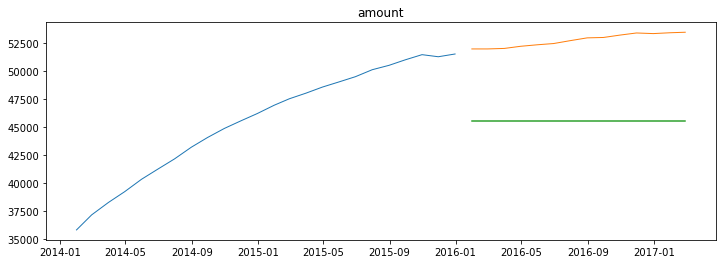

In [36]:
for col in train.columns:
    plot_and_eval(col)

In [37]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)

In [38]:
eval_df

,model_type,target_var,rmse
0,simple_average,amount,7181.0


## Moving Average

In [43]:
period = 6

amounts = round(train['amount'].rolling(period).mean().iloc[-1], 2)

yhat_df = make_predictions()

yhat_df.head()

,amount
month_invoiced,
2016-01-31,50965.83
2016-02-29,50965.83
2016-03-31,50965.83
2016-04-30,50965.83
2016-05-31,50965.83


amount -- RMSE: 1847


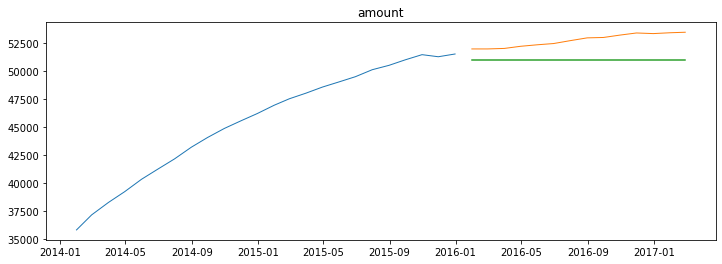

In [44]:
for col in train.columns:
    plot_and_eval(col)

In [45]:
for col in train.columns:
    eval_df = append_eval_df(model_type='6M moving average', 
                             target_var = col)

In [46]:
eval_df

,model_type,target_var,rmse
0,simple_average,amount,7181.0
1,6M moving average,amount,1847.0


In [47]:
periods = [3, 6, 9, 12, 15, 18]

for p in periods:
    amounts = round(train['amount'].rolling(p).mean().iloc[-1], 2)
    yhat_df = make_predictions()
    model_type = str(p) + 'M moving average'
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'amount'
                            )

In [48]:
eval_df

,model_type,target_var,rmse
0,simple_average,amount,7181.0
1,6M moving average,amount,1847.0
2,3M moving average,amount,1436.0
3,6M moving average,amount,1847.0
4,9M moving average,amount,2473.0
5,12M moving average,amount,3164.0
6,15M moving average,amount,3967.0
7,18M moving average,amount,4901.0


In [49]:
min_rmse_amount = eval_df.groupby('target_var')['rmse'].min()[0]

In [50]:
eval_df[((eval_df.rmse == min_rmse_amount)
        )]

,model_type,target_var,rmse
2,3M moving average,amount,1436.0


## Holt's Linear Trend

amount 



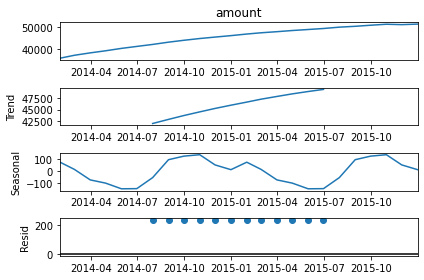

In [51]:
for col in train.columns:
    print(col,'\n')
    _ = sm.tsa.seasonal_decompose(train[col].resample('M').mean()).plot()
    plt.show()

In [52]:
for col in train.columns:
    model = Holt(train[col], exponential = False)
    model = model.fit(smoothing_level = .1, 
                      smoothing_slope = .1, 
                      optimized = False)
    yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

amount -- RMSE: 8103


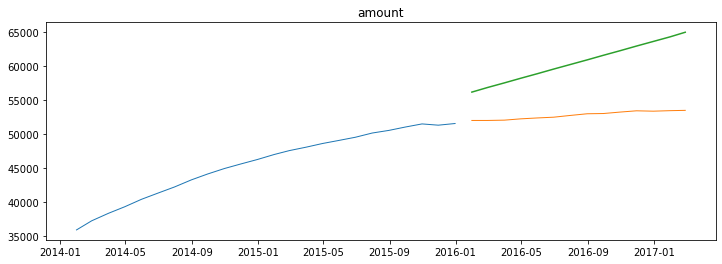

In [53]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [54]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts', 
                             target_var = col)

In [55]:
eval_df

,model_type,target_var,rmse
0,simple_average,amount,7181.0
1,6M moving average,amount,1847.0
2,3M moving average,amount,1436.0
3,6M moving average,amount,1847.0
4,9M moving average,amount,2473.0
5,12M moving average,amount,3164.0
6,15M moving average,amount,3967.0
7,18M moving average,amount,4901.0
8,Holts,amount,8103.0


## Predict Based on Previous Cycle

In [56]:
train = df[:'2015']
validate = df['2016']
test = df['2017']

In [61]:
train.diff(3)

,amount
month_invoiced,
2014-01-31,NaN
2014-02-28,NaN
2014-03-31,NaN
2014-04-30,3405.0
2014-05-31,3165.0
2014-06-30,2960.0
2014-07-31,2915.0
2014-08-31,2855.0
2014-09-30,2820.0


In [57]:
yhat_df = round(train['2015'] + train.diff(1).mean(),2)

In [58]:
pd.concat([yhat_df.head(1), validate.head(1)])

,amount
month_invoiced,
2015-01-31,47625.65
2016-01-31,51955.00


In [59]:
# set yhat_df to index of validate
yhat_df.index = validate.index

len(yhat_df)

amount -- RMSE: 2539


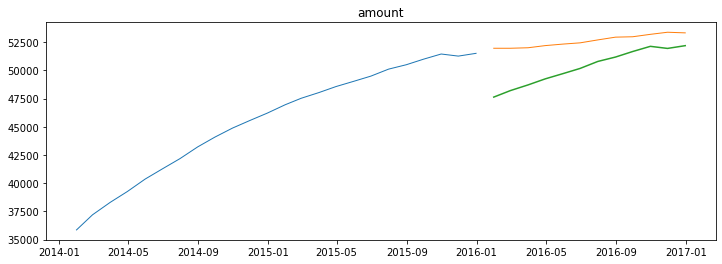

In [62]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'previous year', target_var = col)

In [63]:
eval_df

,model_type,target_var,rmse
0,simple_average,amount,7181.0
1,6M moving average,amount,1847.0
2,3M moving average,amount,1436.0
3,6M moving average,amount,1847.0
4,9M moving average,amount,2473.0
5,12M moving average,amount,3164.0
6,15M moving average,amount,3967.0
7,18M moving average,amount,4901.0
8,Holts,amount,8103.0
9,previous year,amount,2539.0


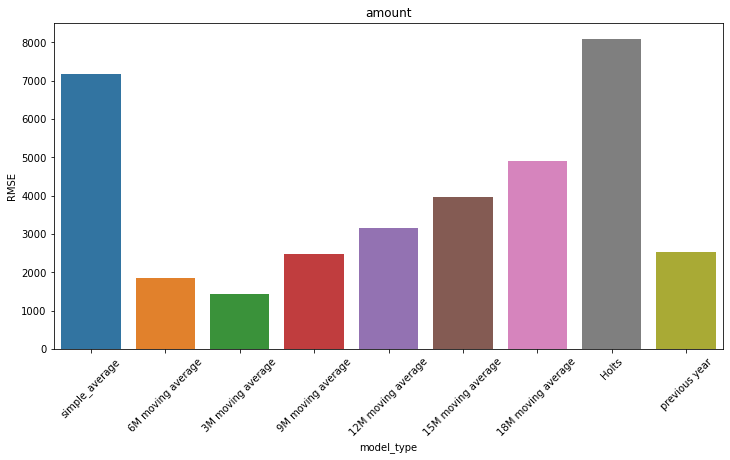

In [64]:
for col in train.columns:
    x = eval_df[eval_df.target_var == col]['model_type']
    y = eval_df[eval_df.target_var == col]['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x, y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.show()

In [81]:
yhat_df = validate + train.diff(3).mean()
yhat_df.index = test.index

In [82]:
rmse_amount = round(sqrt(mean_squared_error(test['amount'], yhat_df['amount'])), 0)

In [83]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(test[target_var], label = 'Test', linewidth = 1)
    plt.plot(yhat_df[target_var], alpha = .5)
    plt.title(target_var)
    plt.show()

rmse - amount:  1095.0


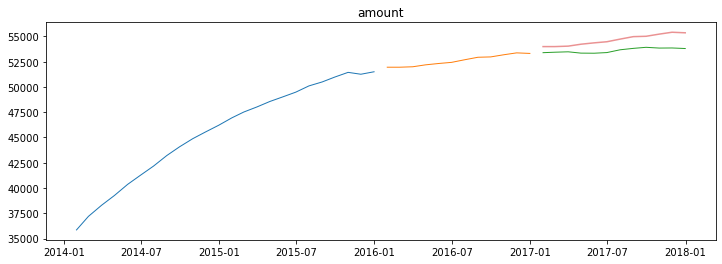

In [84]:
print("rmse - amount: ", rmse_amount)

for col in train.columns:
    plot_and_eval(col)